In [112]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [113]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [114]:
NUM_CLASSES = 7

# Dataset reading

In [115]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [116]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [118]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [119]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_10 (Dropout)        (None, 42)                0         
                                                                 
 dense_15 (Dense)            (None, 20)                860       
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                                 
 dense_16 (Dense)            (None, 10)                210       
                                                                 
 dense_17 (Dense)            (None, 7)                 77        
                                                                 
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________


In [120]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [121]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [122]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/40 [..............................] - ETA: 13s - loss: 2.0505 - accuracy: 0.0938
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
40/40 [==============================] - 0s 4ms/step - loss: 1.9635 - accuracy: 0.1637 - val_loss: 1.9046 - val_accuracy: 0.2642
Epoch 2/1000
 1/40 [..............................] - ETA: 0s - loss: 1.9150 - accuracy: 0.1641
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
40/40 [==============================] - 0s 2ms/step - loss: 1.8921 - accuracy: 0.2404 - val_loss: 1.8445 - val_accuracy: 0.2653
Epoch 3/1000
 1/40 [..............................] - ETA: 0s - loss: 1.9148 - accuracy: 0.2344
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
40/40 [==============================] - 0s 2ms/step - loss: 1.8460 - accuracy: 0.2612 - val_loss: 1.7932 - val_accuracy: 0.2724
Epoch 4/1000
 1/40 [..............................] - ETA: 0s - loss: 1.8742 - accuracy: 0.2344


In [123]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

14/14 [==============================] - 0s 726us/step - loss: 0.6823 - accuracy: 0.7925


In [124]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [125]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 31ms/step
[0.00754639 0.03111145 0.00385508 0.02503537 0.13759929 0.3895421
 0.40531033]
6


# Confusion matrix

53/53 [==============================] - 0s 566us/step


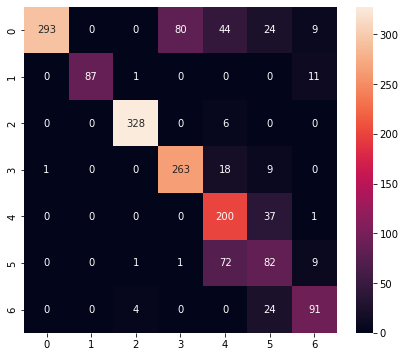

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.65      0.79       450
           1       1.00      0.88      0.94        99
           2       0.98      0.98      0.98       334
           3       0.76      0.90      0.83       291
           4       0.59      0.84      0.69       238
           5       0.47      0.50      0.48       165
           6       0.75      0.76      0.76       119

    accuracy                           0.79      1696
   macro avg       0.79      0.79      0.78      1696
weighted avg       0.83      0.79      0.80      1696



In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [127]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [128]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpfsa5ne3r/assets


INFO:tensorflow:Assets written to: /tmp/tmpfsa5ne3r/assets
2023-03-12 22:39:10.629199: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-12 22:39:10.629219: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-12 22:39:10.629331: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfsa5ne3r
2023-03-12 22:39:10.630253: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-12 22:39:10.630268: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfsa5ne3r
2023-03-12 22:39:10.634028: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-12 22:39:10.660305: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfsa5ne3r
2023-03-12 22:39:10.666330: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

6740

# Inference test

In [129]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [130]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [131]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [132]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 55 µs, sys: 4 µs, total: 59 µs
Wall time: 44.8 µs


In [133]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.00754639 0.03111146 0.00385508 0.02503536 0.13759929 0.38954204
 0.40531036]
6
